In [2]:
# Add project src to path.
import set_path
import glob

# Import modules.
import numpy as np
import time
import logging
from tqdm import tqdm

# Visulatisation
#%matplotlib widget
import matplotlib.pyplot as plt

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.plot_utils as plot_utils
import src.utils.clip_utils as clip_utils
import src.utils.math_utils as math_utils
import src.utils.bgt_utils as bgt_utils

from src.utils.interpolation import FastGridInterpolator

from pyntcloud import PyntCloud
import pandas as pd
from skimage import feature
from scipy import ndimage
import cv2 as cv
import pyransac3d as pyrsc

import open3d as o3d
from shapely.geometry import LineString
import shapely 
from scipy.optimize import curve_fit
import scipy.spatial

from multiprocessing import Pool
from sklearn.cluster import DBSCAN

from skimage.transform import probabilistic_hough_line, hough_line, hough_line_peaks

In [2]:
def plot_cloud(points, labels, plot_3d=True):

    fig = plt.figure()
    if plot_3d:
        ax = plt.axes(projection='3d')
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(points[mask][:,0],points[mask][:,1],points[mask][:,2], s=2, label=str(label))
    else:
        ax = plt.axes()
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(points[mask][:,0],points[mask][:,1], s=1,label=str(label))
    plt.legend()
    plt.show()

In [56]:
def armatuur_analysis(filepath):

    props = []

    for las_file in glob.iglob(filepath):

        tile_code = las_file[-13:-4]

        pointcloud = las_utils.read_las(las_file)
        true_labels = pointcloud.label
        points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
        labels = np.zeros(len(points))

        lamp_mask = true_labels == 14
        if lamp_mask.sum() > 4:
            clustering = (DBSCAN(eps=1, min_samples=2, p=2).fit(points[lamp_mask]))
            for cluster in np.unique(clustering.labels_):
                c_mask = clustering.labels_ == cluster
                cl_pts = points[lamp_mask][c_mask]

                cl_height = cl_pts[:,2].max() - cl_pts[:,2].min()
                min_bounding_rect, hull_points, min_dims, max_dims, center_point = math_utils.minimum_bounding_rectangle(cl_pts[:,:2])

                cc_props = {
                    'tile_code': tile_code,
                    'coord_X': cl_pts[:,0].mean(),
                    'coord_Y': cl_pts[:,1].mean(),
                    'coord_Z': cl_pts[:,2].mean(),
                    'height': cl_height,
                    'box_max': round(max_dims,2),
                    'box_min': round(min_dims,2)
                }

                props.append(cc_props)

    return pd.DataFrame(props)

In [55]:
armatuur_analysis('../datasets/new_dataset/*.laz')

Processing file ../datasets/new_dataset/processed_2434_9724.laz
Processing file ../datasets/new_dataset/processed_2426_9774.laz
Processing file ../datasets/new_dataset/processed_2419_9768.laz
Processing file ../datasets/new_dataset/processed_2404_9680.laz


,tile_code,coord_X,coord_Y,coord_Z,height,box_max,box_min
0,2434_9724,121719.255407,486239.158995,11.013971,0.85,0.50,0.39
1,2434_9724,121723.054940,486222.719322,10.819672,0.86,0.52,0.47
2,2434_9724,121727.598168,486202.647481,10.755954,0.79,0.47,0.38
3,2434_9724,121732.359793,486226.309648,9.236002,0.38,0.60,0.35
4,2434_9724,121717.259317,486221.566854,7.821218,0.45,0.40,0.37
5,2426_9774,121349.108394,488737.383858,11.231457,0.29,0.64,0.62
6,2426_9774,121336.565255,488738.344588,11.343647,0.26,0.59,0.58
7,2426_9774,121322.949837,488739.494939,11.104367,0.39,0.65,0.57
8,2426_9774,121312.467748,488740.359603,11.210265,0.23,0.60,0.56
9,2419_9768,120979.057813,488408.532548,10.612457,0.83,0.48,0.48


In [57]:
df_lamps = pd.read_csv('armatuur_table.csv')

Text(0.5, 0, 'Width (m)')

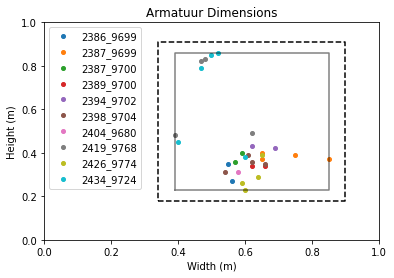

In [73]:
bbox = math_utils.compute_bounding_box(df_lamps.values[:,[5,4]].astype(float))

fig, ax = plt.subplots()
for name, group in df_lamps.groupby('tile_code_new'):
    ax.plot(group.box_max, group.height, marker='o', linestyle='', ms=4, label=name)
ax.plot([bbox[0],bbox[2],bbox[2],bbox[0],bbox[0]],[bbox[1],bbox[1],bbox[3],bbox[3], bbox[1]], c='k', alpha=0.5)
ax.plot([bbox[0]-0.05,bbox[2]+0.05,bbox[2]+0.05,bbox[0]-0.05,bbox[0]-0.05],[bbox[1]-0.05,bbox[1]-0.05,bbox[3]+0.05,bbox[3]+0.05, bbox[1]-0.05], linestyle='--', c='k')
ax.legend()
ax.set_title('Armatuur Dimensions')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_ylabel('Height (m)')
ax.set_xlabel('Width (m)')

In [60]:
tiles = df_lamps.tile_code_new.unique()
plot_utils.plot_tiles_map(tiles, width=400, height=300, zoom_start=12)

### Cable analysis

In [47]:
def cable_analysis(filepath, label):

    props = []

    for las_file in glob.iglob(filepath):

        pointcloud = las_utils.read_las(las_file)
        true_labels = pointcloud.label
        points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
        labels = np.zeros(len(points))

        mask = true_labels == label
        if mask.sum() > 4:
            clustering = (DBSCAN(eps=0.5, min_samples=3, p=2).fit(points[mask]))
            for cluster in np.unique(clustering.labels_):
                c_mask = clustering.labels_ == cluster
                cl_pts = points[mask][c_mask]

                props.append({
                    'min_z': cl_pts[:,2].min(),
                    'max_z': cl_pts[:,2].max()
                })

    return pd.DataFrame(props)

In [49]:
df_1 = cable_analysis('../datasets/*/pointcloud/processed*.laz', 12)

,min_z,max_z
0,5.61,5.78
1,5.67,5.91
2,5.58,5.91
3,5.75,6.05


In [48]:
cable_analysis('../datasets/*/pointcloud/processed*.laz', 13)

,min_z,max_z
0,5.80,7.41
1,5.80,7.86
2,5.93,7.79
3,7.99,8.13


<AxesSubplot:ylabel='Frequency'>

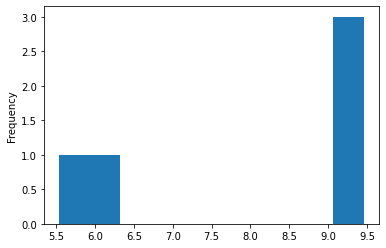

In [52]:
df = cable_analysis('../datasets/*/pointcloud/processed*.laz', 11)
df['min_z'].plot.hist()

In [53]:
df

,min_z,max_z
0,5.54,8.11
1,9.46,10.70
2,9.41,10.97
3,5.99,7.08
4,9.40,10.75
